# Auto Insurance Fraud Data Analysis

### Data Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

In [132]:
fraud = pd.read_excel("FraudDetectionData.xlsx")
fraud.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [133]:
# create a derived variable - the time difference between policy bind date and accident date
fraud["policy-incident"] = fraud['incident_date'] - fraud['policy_bind_date']
fraud["policy-incident"] = fraud["policy-incident"].astype('timedelta64[D]')

In [134]:
# expected correlation between predictors and response variable
fraud = fraud.drop(['policy_bind_date','policy_state','insured_zip','capital-gains','capital-loss','incident_date',\
                    'incident_city','incident_state','incident_location','auto_make','auto_model',"_c39"], axis=1)
fraud = fraud.set_index('policy_number')
fraud.columns

Index([u'months_as_customer', u'age', u'policy_csl', u'policy_deductable',
       u'policy_annual_premium', u'umbrella_limit', u'insured_sex',
       u'insured_education_level', u'insured_occupation', u'insured_hobbies',
       u'insured_relationship', u'incident_type', u'collision_type',
       u'incident_severity', u'authorities_contacted',
       u'incident_hour_of_the_day', u'number_of_vehicles_involved',
       u'property_damage', u'bodily_injuries', u'witnesses',
       u'police_report_available', u'total_claim_amount', u'injury_claim',
       u'property_claim', u'vehicle_claim', u'auto_year', u'fraud_reported',
       u'policy-incident'],
      dtype='object')

#### Hypotheses

- months_as_customer, policy-incident: Fraud might be conducted from new customers(negative correlation expected)
- policy_csl, policy_deductable, policy_annual_premium, umbrella_limit : Fraud might be conducted with high limit of coverages(& low deductible)
- insurance education level, insured occupation, insured hobbies, insured relationship: There could be demographic patterns for fraud
- incident type, collision type, incident severity, authorities contacted : accident pattern 
- total claim amount(BI, PD seperately): claims amount pattern

In [135]:
# Missing values
fraud.isnull().sum()[fraud.isnull().sum()>0]

Series([], dtype: int64)

In [136]:
fraud_numeric = fraud.select_dtypes(exclude="object")
fraud_categorical = fraud.select_dtypes(include="object")

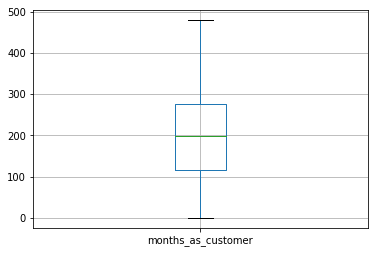

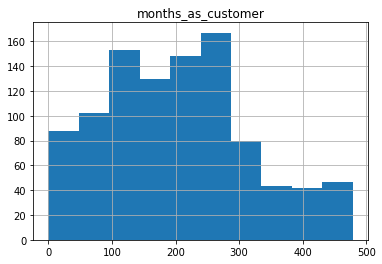

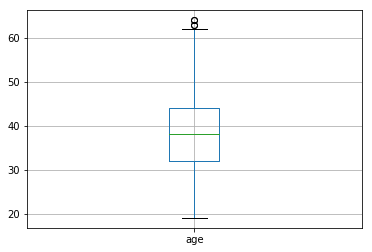

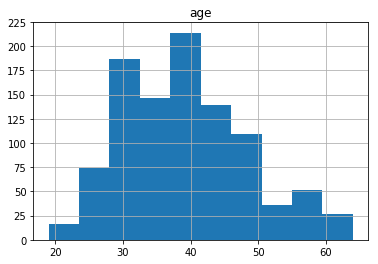

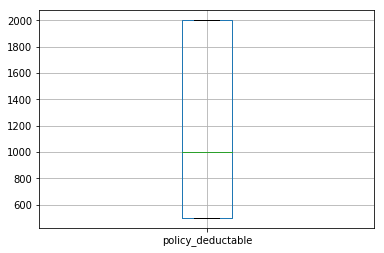

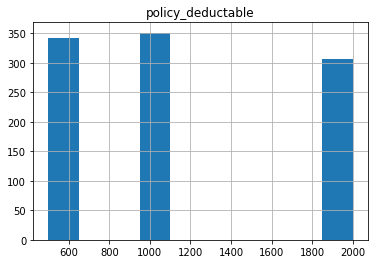

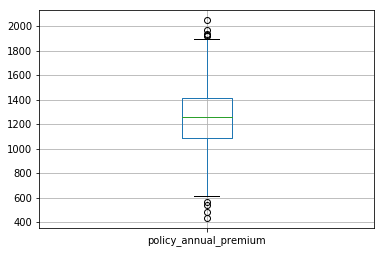

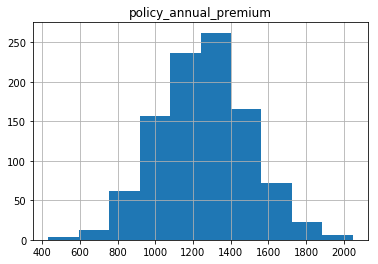

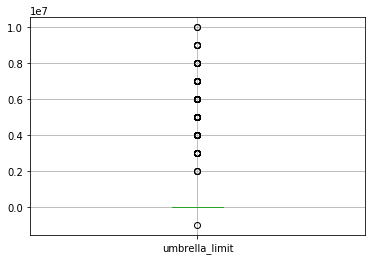

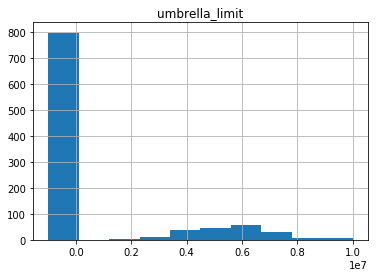

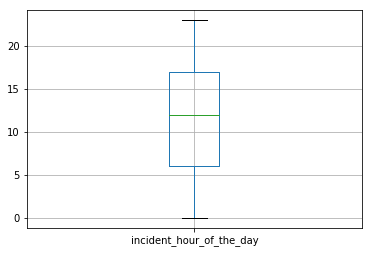

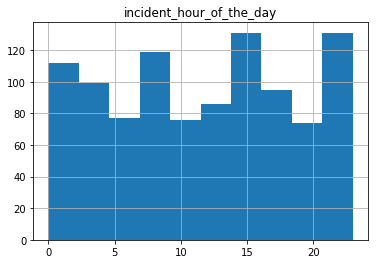

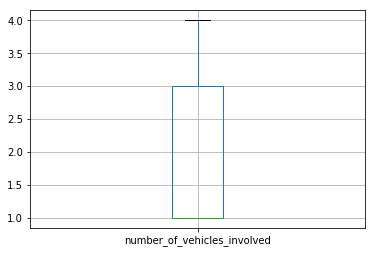

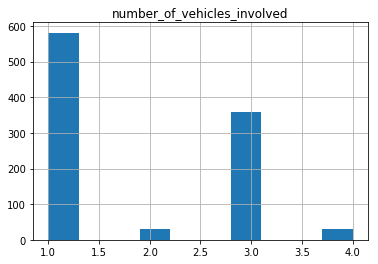

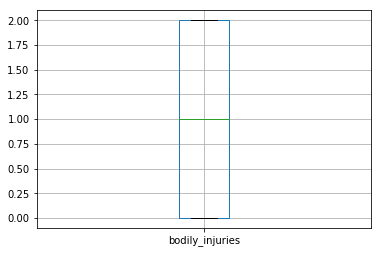

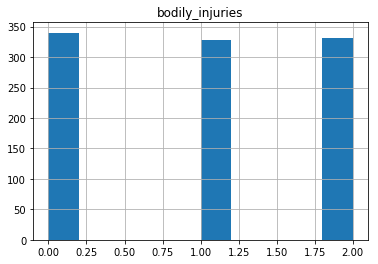

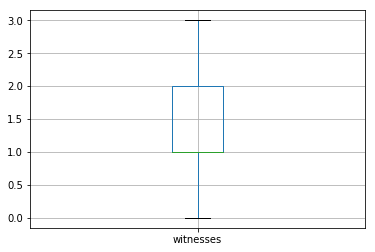

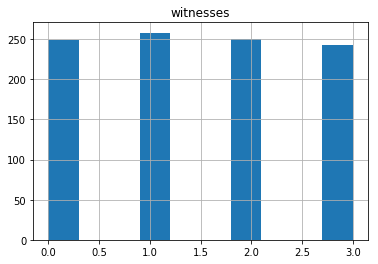

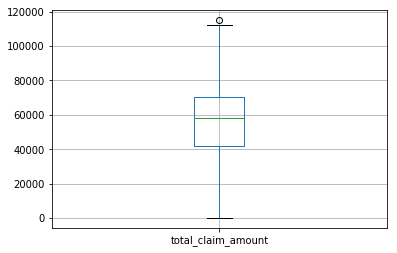

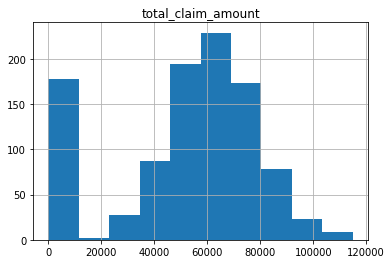

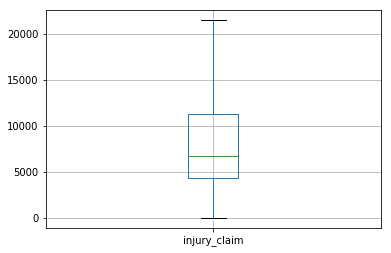

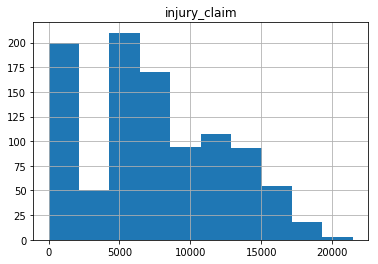

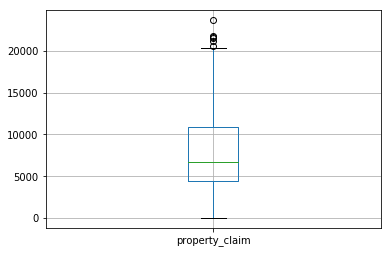

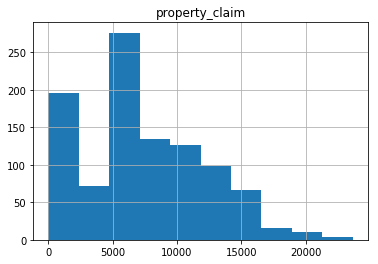

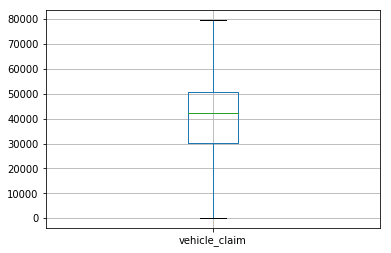

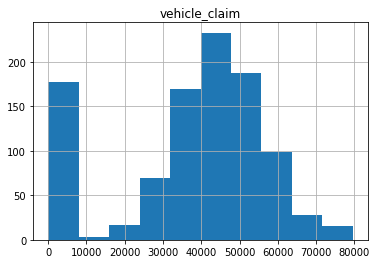

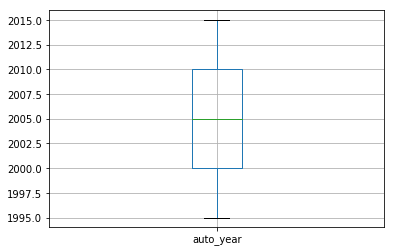

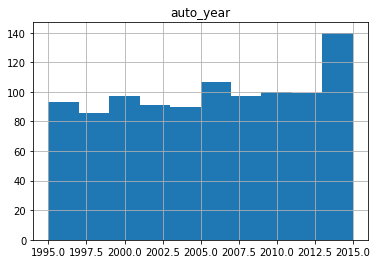

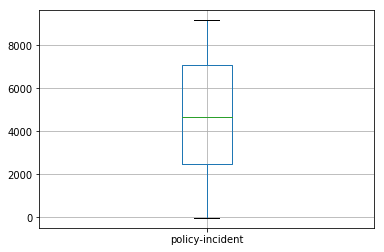

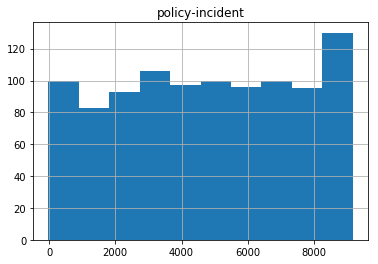

In [137]:
for i in fraud_numeric.columns:
    fraud.boxplot(column=i)
    fraud.hist(column=i)
    plt.show()

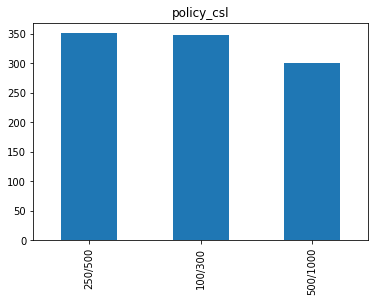

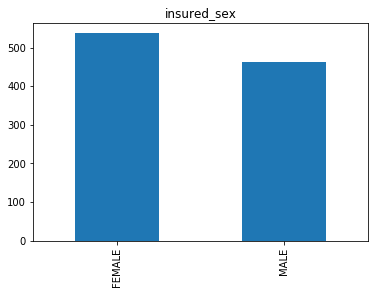

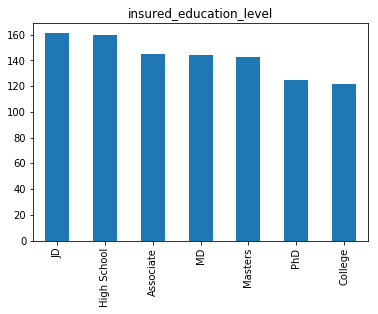

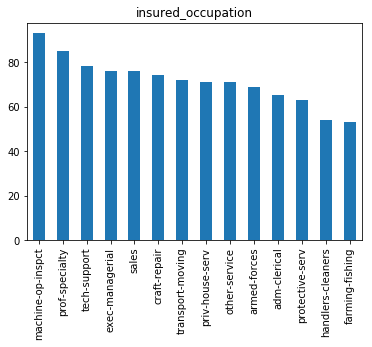

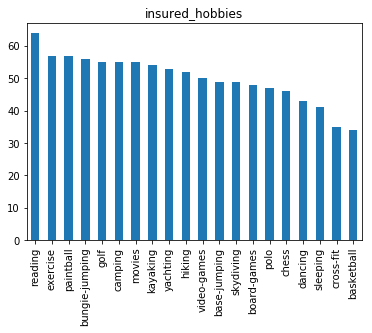

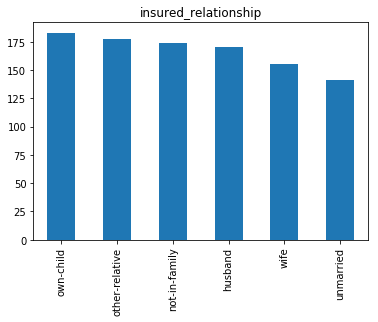

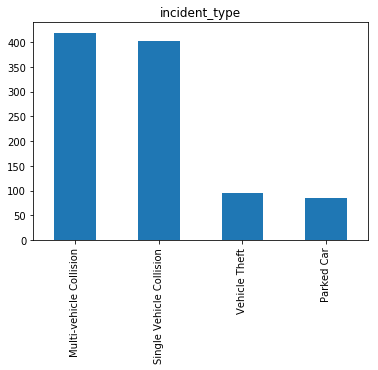

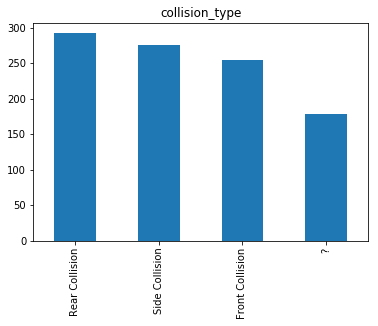

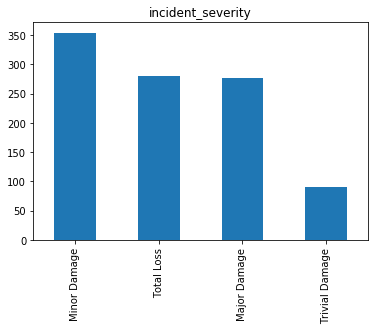

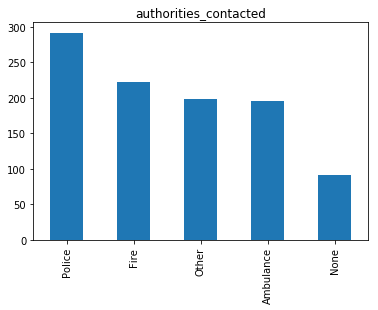

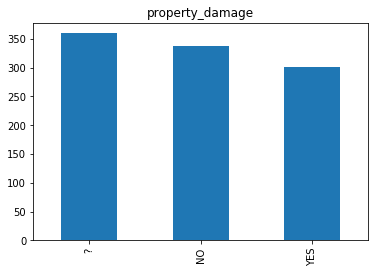

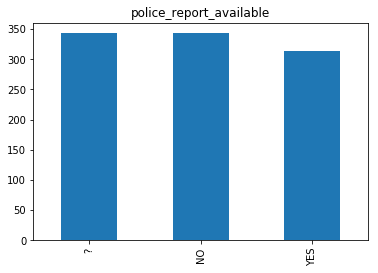

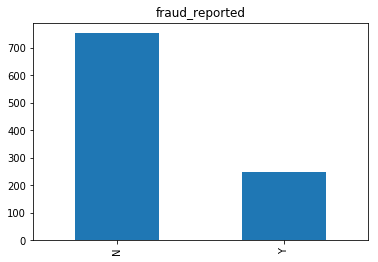

In [138]:
for i in fraud_categorical.columns:
    fraud[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

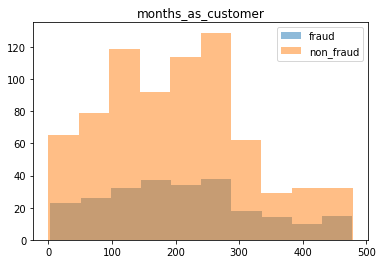

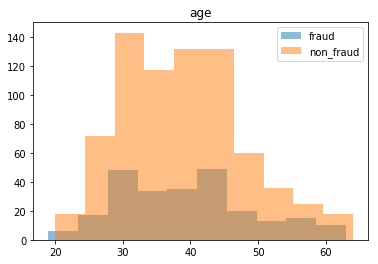

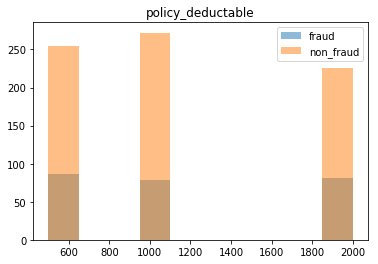

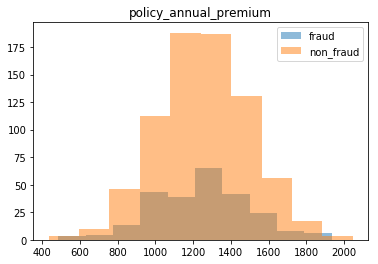

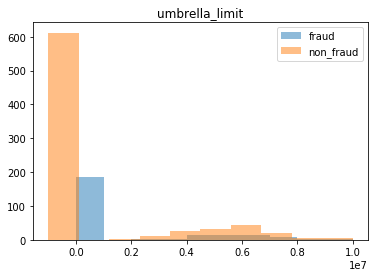

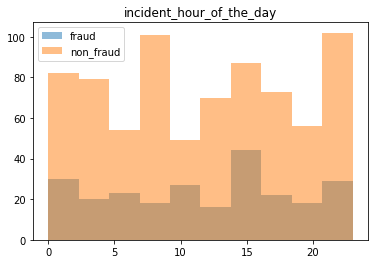

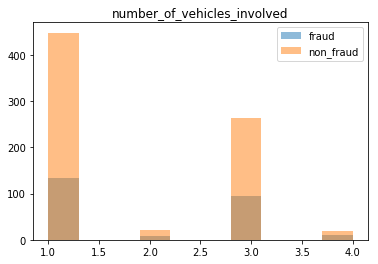

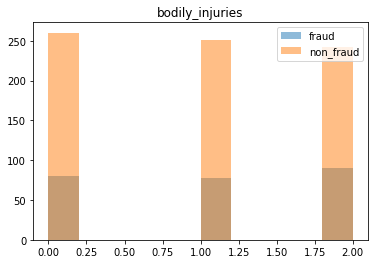

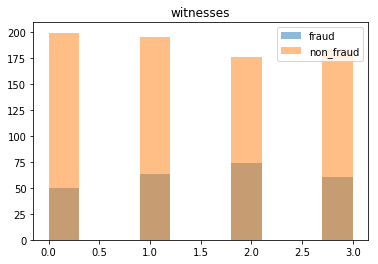

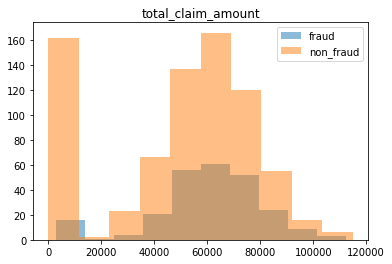

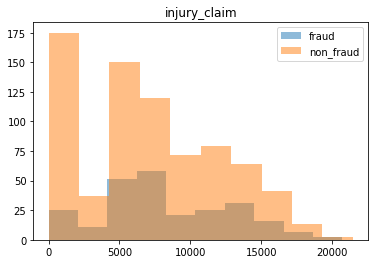

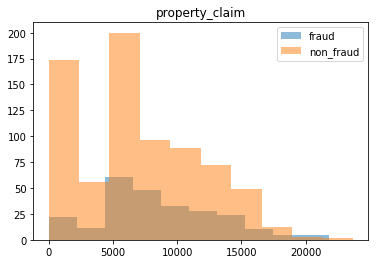

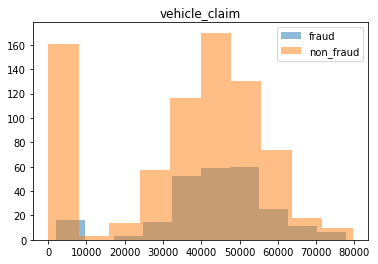

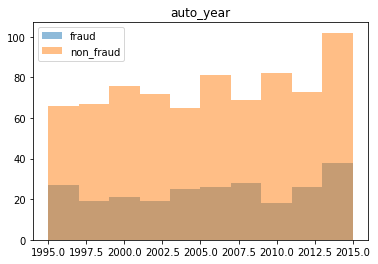

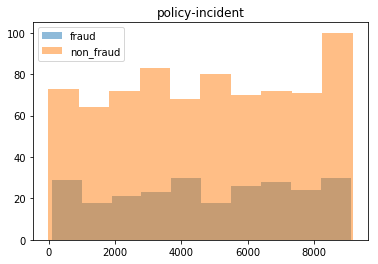

In [139]:
for i in fraud_numeric.columns:
    plt.hist(fraud[fraud["fraud_reported"]=="Y"][i],label="fraud", alpha=0.5)
    plt.hist(fraud[fraud["fraud_reported"]=="N"][i],label="non_fraud", alpha=0.5)
    plt.legend()
    plt.title(i)
    plt.show()

In [167]:
def piechart(x):
    for i in list(fraud['fraud_reported'].unique()):
        ds_sub = fraud[fraud['fraud_reported']==i]
        ds_count = ds_sub.groupby(x).agg("count")
        ds_count.plot.pie(y='fraud_reported',autopct='%1.1f%%')
        plt.legend(loc='best', bbox_to_anchor=(1.0, 1.0))
        plt.title(i)
        plt.show()

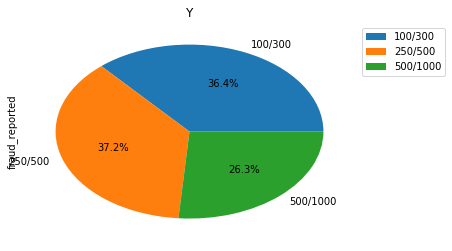

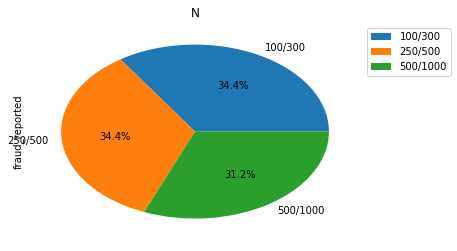

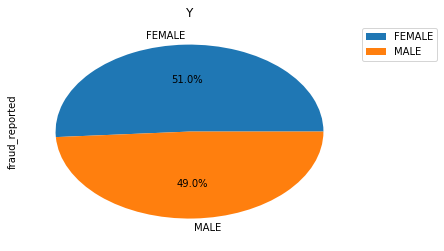

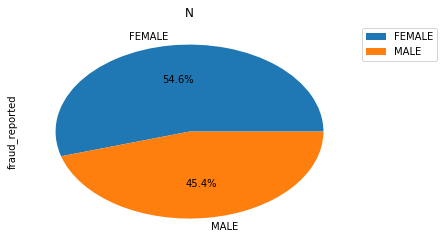

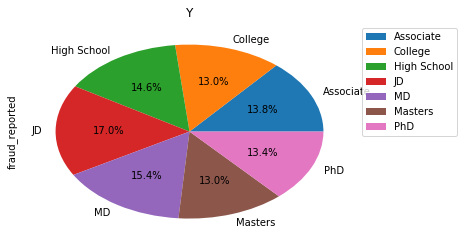

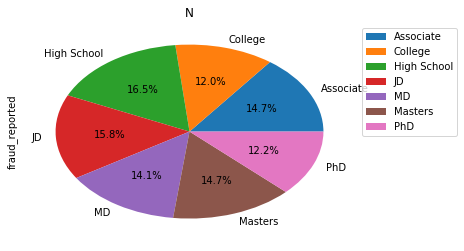

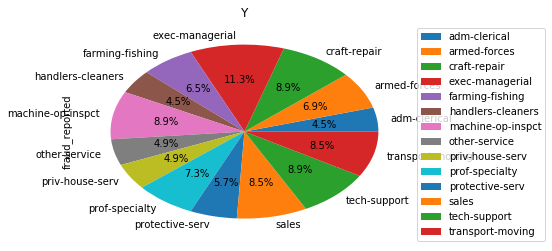

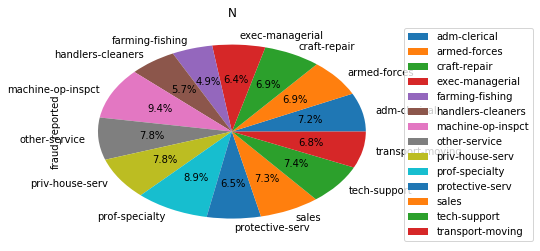

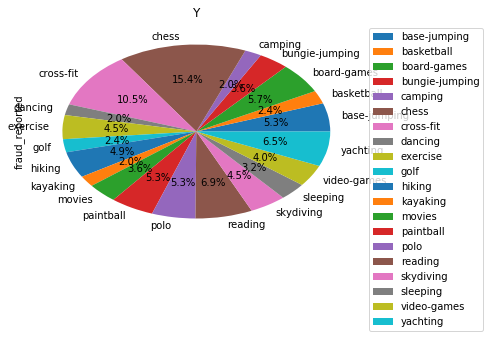

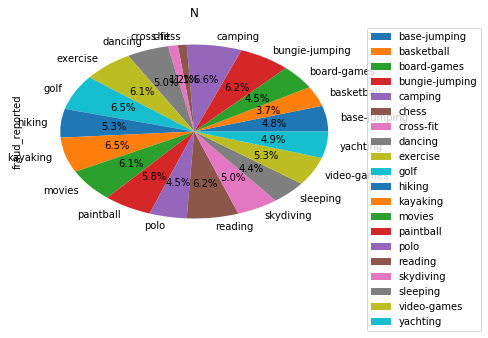

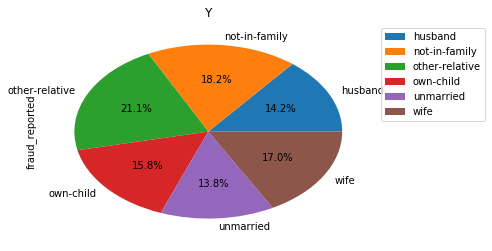

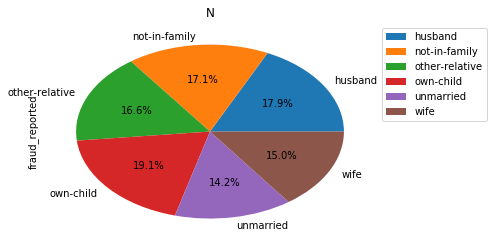

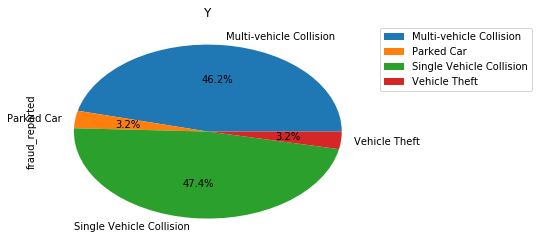

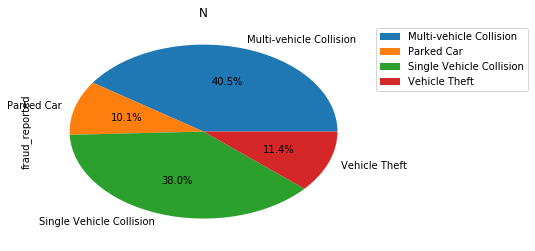

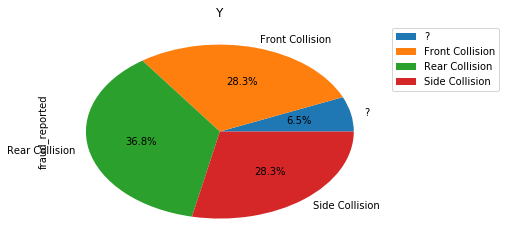

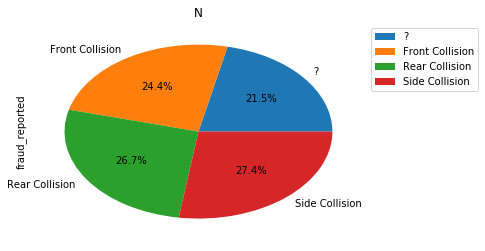

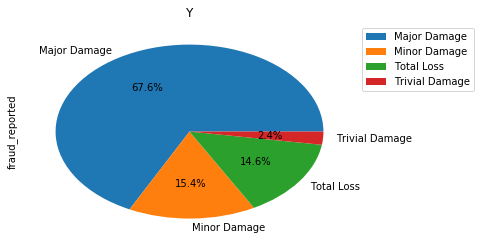

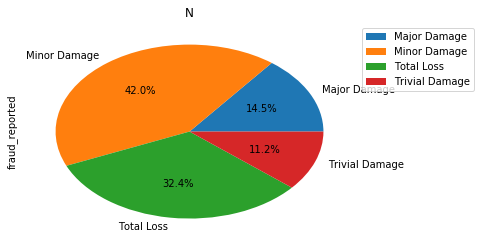

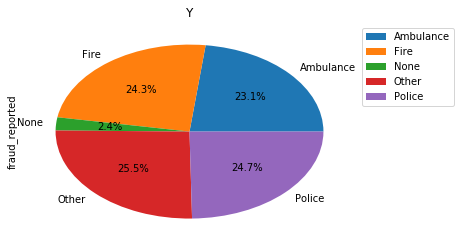

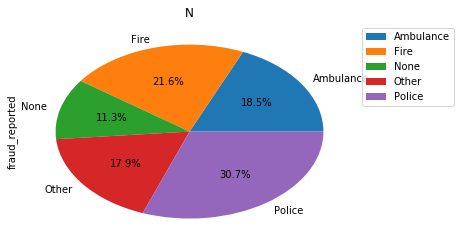

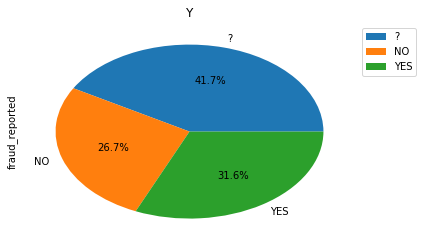

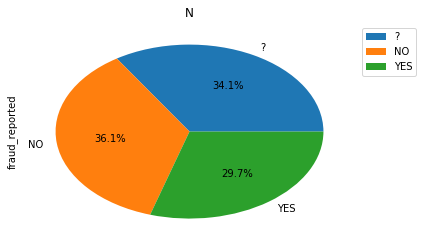

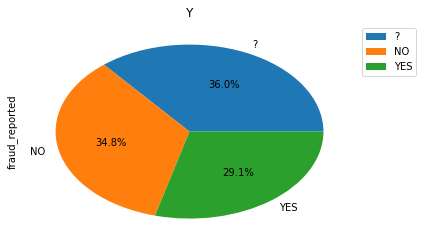

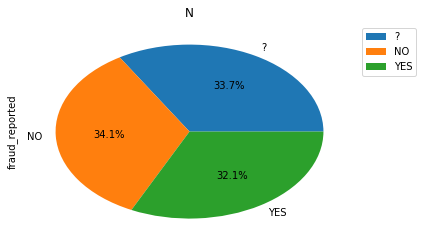

KeyError: 'fraud_reported'

In [168]:
for i in fraud_categorical.columns:
    piechart(i)

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [172]:
fraud_x=fraud.drop(["fraud_reported"], axis=1, inplace=False)
fraud_x=pd.get_dummies(fraud_x)
fraud_y=fraud["fraud_reported"]
fraud_train_x, fraud_test_x, fraud_train_y, fraud_test_y = train_test_split(fraud_x, fraud_y, test_size=0.3, random_state=1234)

print("train data X size:",fraud_train_x.shape)
print("train data Y size:",fraud_train_y.shape)
print("test data X size:",fraud_test_x.shape)
print("test data Y size:",fraud_test_y.shape)

('train data X size:', (700, 90))
('train data Y size:', (700L,))
('test data X size:', (300, 90))
('test data Y size:', (300L,))


In [173]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(fraud_train_x, fraud_train_y)
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(fraud_train_x,fraud_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(fraud_test_x,fraud_test_y)))

Accuracy on training set: 0.991
Accuracy on test set: 0.810


C:\Users\yeong\Anaconda3\envs\py27\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
